In [ ]:
library(tidyr)
library("pxweb")
library("tidyverse")
library("GGally")
library("ggpubr")
library(gridExtra)
library(cowplot)
fig <- function(width, heigth) {
    options(repr.plot.width = width, repr.plot.height = heigth)
}


Använd kommandot jupyter nbconvert --to notebook --config jupyter_nbconvert_config.json --output new_notebook.ipynb project.ipynb i anaconda terminalen för att kompilera 

As im approaching my Bachelor's thesis i started thinking about how many other Swedes would graduate "with me". This in turn made me remember that alot of people started studying during the pandemic, partly i think because the decrease in jobs and the decline of the economy. 

Because of these thoughts i decided to investigate how the amount of people graduating from Universities and College in Sweden is affected by different factors such as their gender and the consumer price index among other things.

I started by looking at the data available from Statistics Sweden, where i found data about [awarded degrees](https://www.statistikdatabasen.scb.se/pxweb/sv/ssd/START__UF__UF0550__UF0550C/Historisk11bN/) by gender and academic year, [Sweden's population](https://www.statistikdatabasen.scb.se/pxweb/sv/ssd/START__BE__BE0101__BE0101G/BefUtvKon1749/) by gender and year ,[average yearly income](https://www.statistikdatabasen.scb.se/pxweb/sv/ssd/START__HE__HE0103__HE0103A/ArbInk28/) by gender and year and [consumer price index](https://www.statistikdatabasen.scb.se/pxweb/sv/ssd/START__HE__HE0103__HE0103A/ArbInk28/) by year.

After finding the data it was time to import it into R, this was simple as Statistics Sweden have their own API.

In [ ]:
API_wait <- 1e-3
pxq_edu <-
  list(
    "Examen" = c("*"),
    "Kon" = c("*"),
    "ContentsCode" = c("000004NE"),
    "Tid" = c("*")
  )
pxg_edu <- pxweb_get("https://api.scb.se/OV0104/v1/doris/sv/ssd/START/UF/UF0550/UF0550C/Historisk11bN", pxq_edu)
Sys.sleep(API_wait) # To prevent overloading the API

pxq_pop <-
  list(
    "Kon" = c("*"),
    "ContentsCode" = c("000000LV"),
    "Tid" = c("*")
  )

pxg_pop <- pxweb_get("https://api.scb.se/OV0104/v1/doris/sv/ssd/START/BE/BE0101/BE0101G/BefUtvKon1749", pxq_pop)
Sys.sleep(API_wait)


pxq_income <- list(
  "Kon" = c("*"),
  "Tid" = c("*"),
  "ContentsCode" = c("HE0103CL")
)
pxg_income <- pxweb_get("https://api.scb.se/OV0104/v1/doris/sv/ssd/START/HE/HE0103/HE0103A/ArbInk28", pxq_income)
Sys.sleep(API_wait)

pxq_kpi <- list(
  "Tid" = c("*"),
  "ContentsCode" = c("000004VU")
)
pxg_kpi <- pxweb_get("https://api.scb.se/OV0104/v1/doris/sv/ssd/START/PR/PR0101/PR0101A/KPItotM", pxq_kpi)


After gathering the data it is time to clean it and combine all the different sources into a single tibble.

In [ ]:
edu_df <- as.data.frame(pxg_edu)
edu_df <- as_tibble(edu_df)

doktor_df <- edu_df %>%
    filter(examen %in% c("Doktorsgrad", "Doktorsexamen")) %>%
    group_by(läsår, kön) %>%
    mutate(`Utfärdade examina vid universitet och högskolor` = sum(`Utfärdade examina vid universitet och högskolor`)) %>%
    filter(examen == "Doktorsexamen") %>%
    ungroup()


licenciat_df <- edu_df %>%
    filter(examen %in% c("Licentiatexamen", "Licentiatexamen (Äldre)")) %>%
    group_by(läsår, kön) %>%
    mutate(`Utfärdade examina vid universitet och högskolor` = sum(`Utfärdade examina vid universitet och högskolor`)) %>%
    filter(examen == "Licentiatexamen") %>%
    ungroup()


edu_df <- edu_df %>%
    filter(examen == "Examen från grundutbildning") %>%
    full_join(licenciat_df) %>%
    full_join(doktor_df) %>%
    pivot_wider(names_from = kön, values_from = `Utfärdade examina vid universitet och högskolor`) %>%
    mutate(läsår = as.integer(str_extract(läsår, "^\\w*"))) %>%
    rename(år = läsår) %>%
    pivot_longer(!c(år, examen), names_to = "kön", values_to = "antal") %>%
    mutate(
        kön = str_replace(kön, "båda könen", "totalt"),
        examen = factor(examen,
            ordered = FALSE,
            levels = c(
                "Examen från grundutbildning", "Licentiatexamen", "Licentiatexamen (Äldre)", "Doktorsgrad", "Doktorsexamen"
            ),
            labels = c(
                "Grundutbildning", "Licentiatexamen", "Licentiatexamen", "Doktorsexamen", "Doktorsexamen"
            )
        )
    )

pop_df <- as.data.frame(pxg_pop)
pop_df <- as_tibble(pop_df) %>% mutate(år = as.integer(år)) # %>%



income_df <- as.data.frame(pxg_income)
income_df <- as_tibble(income_df) %>%
    filter(år >= 1936) %>%
    mutate(år = as.integer(år))


kpi_df <- as.data.frame(pxg_kpi)
kpi_df <- as_tibble(kpi_df) %>%
    mutate(månad = str_extract(månad, "(20|19)[\\d]{2}")) %>%
    rename("år" = "månad") %>%
    group_by(år) %>%
    mutate(år = as.integer(år)) %>%
    summarize(`AVG_KPI_Fastställd` = mean(`KPI, fastställda tal`)) %>%
    ungroup()


final_df <- edu_df %>%
    left_join(income_df, by = join_by("år", kön == kön)) %>%
    left_join(kpi_df, by = "år") %>%
    left_join(pop_df, by = join_by("år", kön == kön)) %>%
    rename(medelinkomst = `Medelvärde, tkr`) %>%
    mutate(kön = factor(kön, levels = c("totalt", "kvinnor", "män"), ordered = FALSE)) %>%
    drop_na()

final_df %>% filter(år == 1980)


Once the data is in a usable format its time to do some exploratory data analysis.
First we look at a scatterplot to get an understanding for the relation between awarded degrees and average income and then we will look at a pairs plot.


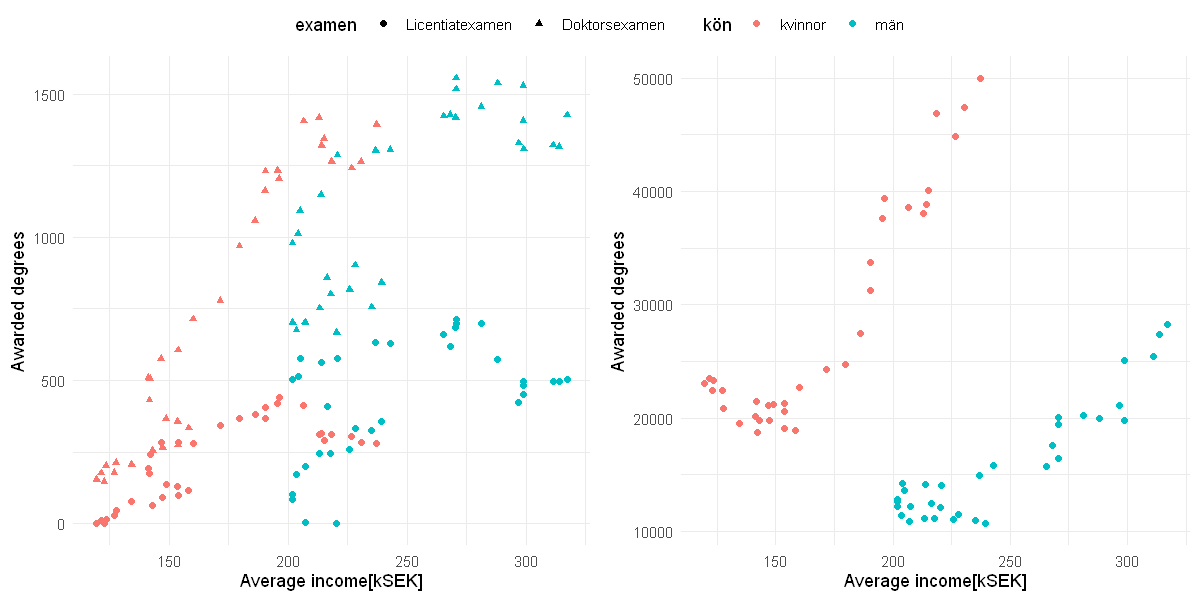

In [ ]:
fig(10, 5)
income_deg_plot1 <- ggplot(data = final_df %>% filter(examen != "Grundutbildning", kön != "totalt")) +
  geom_point(aes(x = medelinkomst, y = antal, color = kön, shape = examen)) +
  theme_minimal() +
  labs(x = "Average income[kSEK]", y = "Awarded degrees")

income_deg_plot2 <- ggplot(data = final_df %>% filter(examen == "Grundutbildning", kön != "totalt")) +
  geom_point(aes(x = medelinkomst, y = antal, color = kön, shape = examen)) +
  theme_minimal() +
  labs(x = "Average income[kSEK]", y = "Awarded degrees")


ggarrange(nrow = 1, ncol = 2, common.legend = TRUE, income_deg_plot1, income_deg_plot2)


On the left we have Licenciat and PHD degrees as dots and triangles respectively, on the right we have Bachelor's degrees. The red datapoints are women and the blue men, not also that average income is not overall but by gender.  We can see that the number of degrees are somewhat similiar between the genders for Licenciat and PHD regardless of average income. But on the Bachelor's wee can see that women are awarded more degrees than men regardless of average income. We can also see that the number of degrees grows with income in both plots.

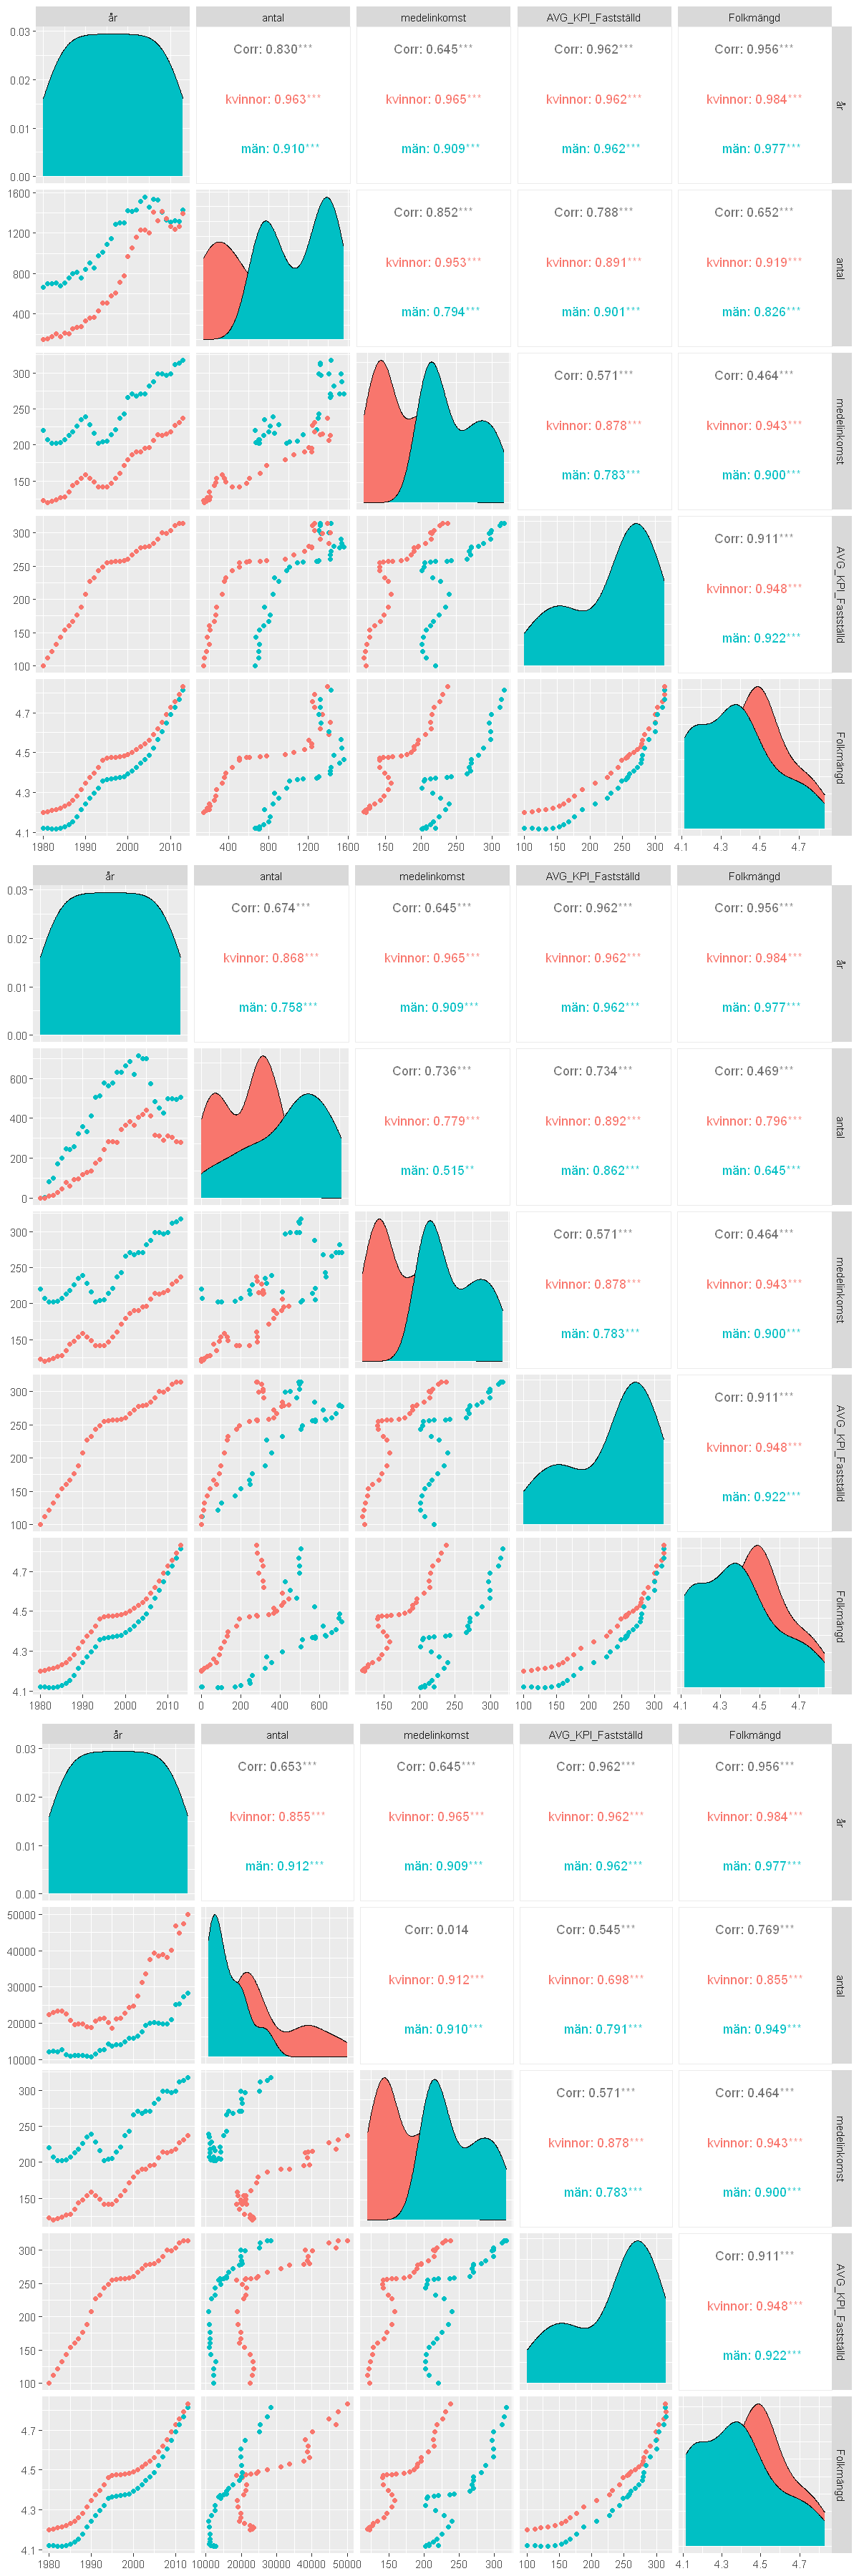

In [207]:
dok_df <- final_df %>%
    filter(examen == "Doktorsexamen", kön != "totalt") %>%
    mutate(Folkmängd = 1e-6 * Folkmängd)

lic_df <- final_df %>%
    filter(examen == "Licentiatexamen", kön != "totalt") %>%
    mutate(Folkmängd = 1e-6 * Folkmängd)

grund_df <- final_df %>%
    filter(examen == "Grundutbildning", kön != "totalt") %>%
    mutate(Folkmängd = 1e-6 * Folkmängd)

dok_pairs <- ggpairs(
    data = dok_df,
    columns = c("år", "antal", "medelinkomst", "AVG_KPI_Fastställd", "Folkmängd"),
    mapping = aes(color = kön)
)

lic_pairs <- ggpairs(
    data = lic_df, columns = c("år", "antal", "medelinkomst", "AVG_KPI_Fastställd", "Folkmängd"),
    mapping = aes(color = kön)
)

grund_pairs <- ggpairs(
    data = grund_df, columns = c("år", "antal", "medelinkomst", "AVG_KPI_Fastställd", "Folkmängd"),
    mapping = aes(color = kön)
)

plot_grid(
    ggmatrix_gtable(dok_pairs), ggmatrix_gtable(lic_pairs), ggmatrix_gtable(grund_pairs),
    ncol = 1
)
fig(10, 30)


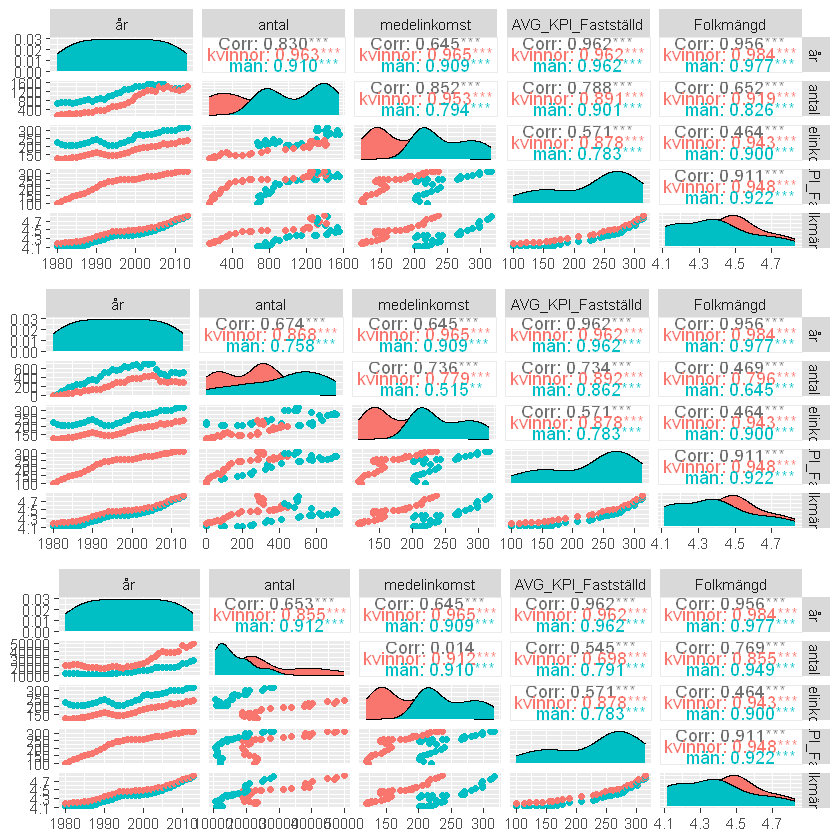

In [150]:
dok_df <- final_df %>%
    filter(examen == "Doktorsexamen", kön != "totalt") %>%
    mutate(Folkmängd = 1e-6 * Folkmängd)

lic_df <- final_df %>%
    filter(examen == "Licentiatexamen", kön != "totalt") %>%
    mutate(Folkmängd = 1e-6 * Folkmängd)

grund_df <- final_df %>%
    filter(examen == "Grundutbildning", kön != "totalt") %>%
    mutate(Folkmängd = 1e-6 * Folkmängd)

dok_pairs <- ggpairs(
    data = dok_df,
    columns = c("år", "antal", "medelinkomst", "AVG_KPI_Fastställd", "Folkmängd"),
    mapping = aes(color = kön)
)

lic_pairs <- ggpairs(
    data = lic_df, columns = c("år", "antal", "medelinkomst", "AVG_KPI_Fastställd", "Folkmängd"),
    mapping = aes(color = kön)
)

grund_pairs <- ggpairs(
    data = grund_df, columns = c("år", "antal", "medelinkomst", "AVG_KPI_Fastställd", "Folkmängd"),
    mapping = aes(color = kön)
)

plot_grid(
    ggmatrix_gtable(dok_pairs), ggmatrix_gtable(lic_pairs), ggmatrix_gtable(grund_pairs),
    ncol = 1
)


We can see that there is some collinearity between some of the columns and that it differs between different types of degrees.

As a naive approach the first model will contain all available data in the multiple linear regression for the amount of graduates.

In [ ]:
naive_model2 <- lm(antal ~ år + kön + examen + medelinkomst + AVG_KPI_Fastställd, data = final_df %>% filter(kön != "totalt"))
summary(naive_model2)


This naive model results in a relatively high $R^2$ and $R_{adj}^{2}$ values of $R^2=0.836, R_{adj}^{2}=0.830$. The most significant regressors were the average KPI that year and if the degree was a "Licenciat" or PH. That the type of degree was significant is not at all unexpected as a Bachelor's level degree is a prerequesite for further studies. That KPI was significant could hint at the state of the economy being important in people studying or not. But the model is quite hard to interpret as a person, because of the large amount of explanatory variables. Because of this the regressor with the highest $p$-value was removed from the model, this being the population variable.

The new model had $R^2=0.836, R_{adj}^{2}=0.831$ meaning it performed slightly better than the naive model. Altough it should be noted that all of the $p$-values barely changed.

In order to increase the interpretability of the model and to more easily choose our variables, we will instead create two new models one for the amount of people graduating with a Bachelor's level degree and another for the amount of people graduating with either a "Licenciat" or PHD.

We will also aproach the problem of choosing variables in the opposite way from what was done to the naive model, that is we will add one variable at a time instead of removing them.


In [ ]:
bachelor_model <- lm(antal ~ ., data = final_df %>% filter(examen == "Grundutbildning", kön != "totalt") %>% select(!examen))
ols_step_forward_p(bachelor_model)

higher_ed_model <- lm(antal ~ ., data = final_df %>% filter(examen != "Grundutbildning", kön != "totalt") %>% mutate(examen = factor(examen)))
ols_step_forward_p(higher_ed_model)


The variable selection algorithm for the Bachelor's level model resulted in the following choices:
1. Population
2. Gender
3. Average income
4. Average KPI
5. Year

On first glance this result was surprising to me as the first variable it chose was population in contrast to the naive model were it had the largest $p$-values, and that the variable with the lowest $p$-value except type of degree was added second to last.

Altough from the pairs plot we knew that there was collinearity between some of the variables so it is to be excpected that they would interact in nonintuitive ways. 

For the model of the other two degrees, forward selection resulted in the choices: